# Computational Finance Research Notebook

## Load data and Packages

In [1]:
#Load libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from module import * 

In [2]:
#Load data in for in-sample
tickers = ["TSLA", "AAPL", "AMD"]
start = "2010-01-01"
end = "2019-12-31"

df_prices, df_changes = download_stock_price_data(tickers, start, end)

[*********************100%***********************]  3 of 3 completed


In [3]:
#Load data in for out-of-sample
test_start = "2020-01-01"
test_end = "2024-12-31"

test_df_prices, test_df_changes = download_stock_price_data(tickers, test_start, test_end)

[*********************100%***********************]  3 of 3 completed


## Signal 1: Moving Average Crossover with MACD Indicator

#### 1.A) Define signal

In [4]:
def signal01(prices, short_ma, long_ma, short_macd, long_macd, signal_window_macd):

    #MA Signal
    ma_sig = ma_signal(prices, short_ma, long_ma)

    #MACD Signal
    macd_sig = signal_macd(prices, short_macd, long_macd, signal_window_macd)

    #Combine Signals
    combined = combine_two_subsignals(ma_sig['signal'], macd_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['ma_position_change'] = ma_sig['position_change']
    signals['macd_position_change'] = macd_sig['position_change']

    return signals

#### 1.B) Gridsearch best parameters for training set

For the parameter space we choose these parameters because in this literature ...

In [5]:
param_grid = {
    'short_ma': [10, 20, 30, 40, 50],
    'long_ma': [55, 75, 100, 125, 150, 175, 200],
    'short_macd': [12],
    'long_macd': [26],
    'signal_window_macd': [9]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal01, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(5))


=== Results for TSLA ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd  cumret  b&h cumret  sharpe  b&h sharpe
0        10       55          12         26                   9     NaN         NaN     NaN         NaN
1        10       75          12         26                   9     NaN         NaN     NaN         NaN
2        10      100          12         26                   9     NaN         NaN     NaN         NaN
3        10      125          12         26                   9     NaN         NaN     NaN         NaN
4        10      150          12         26                   9     NaN         NaN     NaN         NaN

=== Results for AAPL ===
   short_ma  long_ma  short_macd  long_macd  signal_window_macd    cumret  b&h cumret    sharpe  b&h sharpe
0        20      175          12         26                   9  5.930272    9.958795  1.021562    1.061273
1        20      150          12         26                   9  5.409060    9.958795  0.994587    1.061273


#### 1.C) Evaluate parameters on test set

We decide to evalute the best parameters on the 2020 to 2024 market regime because...

In [6]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal01(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD
Strategy Cumulative Return,5.623264,1.987037,2.022953
BuyHold Cumulative Return,13.552015,2.464475,1.493686
Strategy Sharpe,1.000151,1.046838,0.722076
BuyHold Sharpe,1.134808,0.945262,0.611055
Sharpe Delta,-0.134657,0.101575,0.111020
Strategy Max Drawdown,0.599964,0.297835,0.438641
BuyHold Max Drawdown,0.736322,0.314273,0.654499
Strategy Volatility,0.508077,0.236429,0.441598
BuyHold Volatility,0.671894,0.316891,0.524764


#### 1.D) Analysis and Graphs

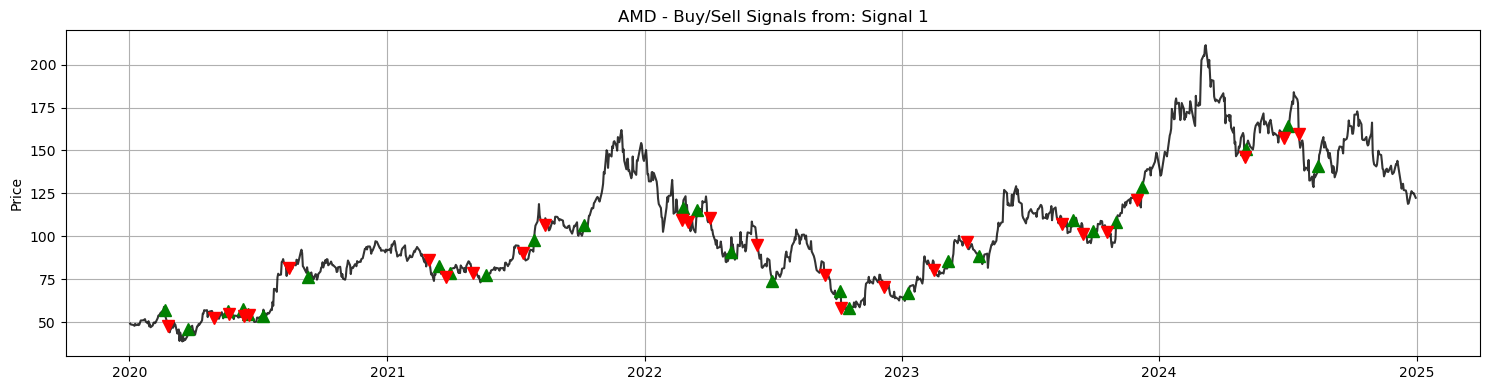

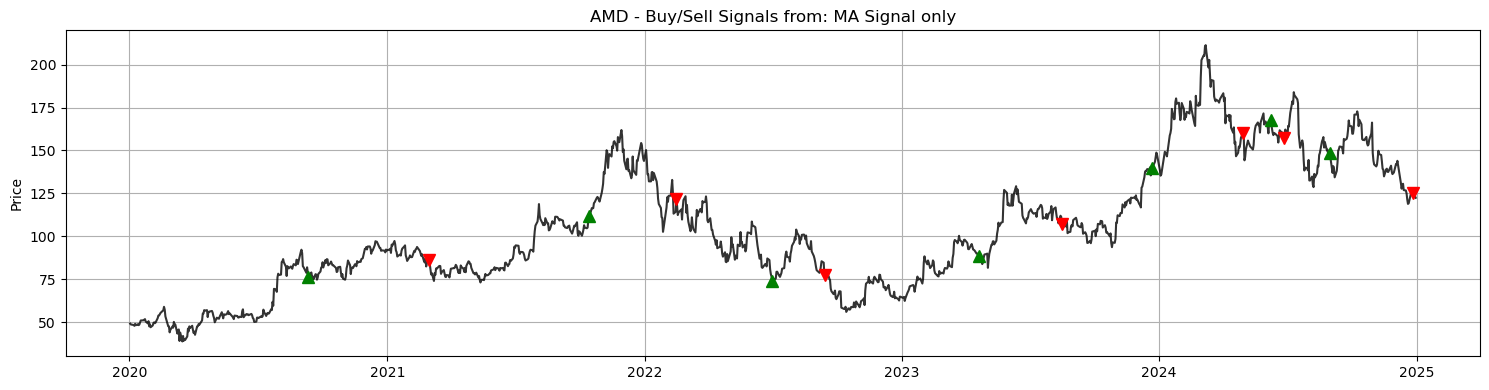

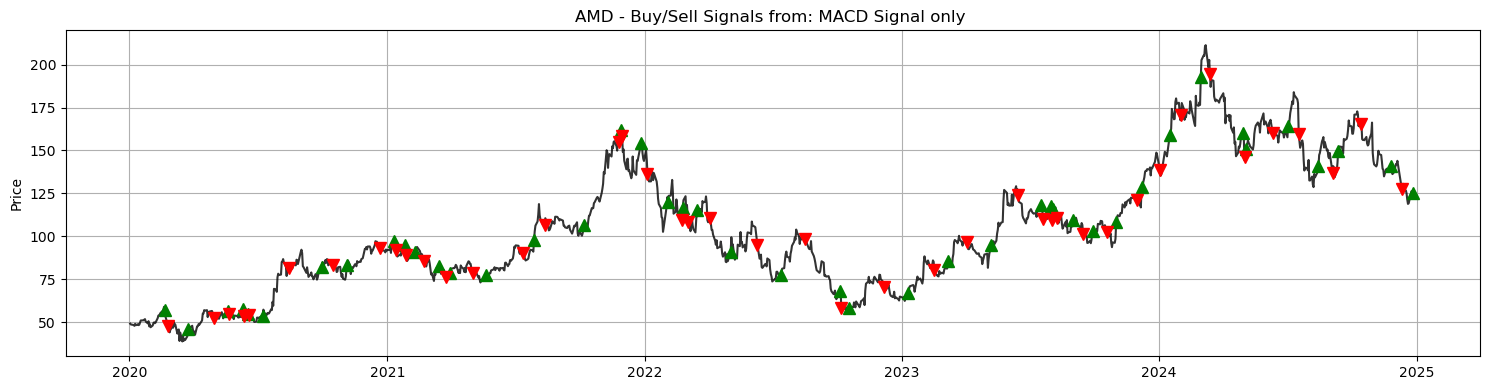

In [7]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, 'AMD', 'Signal 1')
plot_buy_and_sell_signals(signal['ma_position_change'], test_df_prices, 'AMD', 'MA Signal only')
plot_buy_and_sell_signals(signal['macd_position_change'], test_df_prices, 'AMD', 'MACD Signal only ')

## Signal 2: RSI with Bollinger Bands

#### 2.A) Define signal

In [8]:
def signal02(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound, bollinger_window_length, bollinger_n_stds):

    #RSI Signal
    rsi_sig= signal_rsi(prices, rsi_window_length, lower_rsi_bound, upper_rsi_bound)

    #Bollinger Signal
    bollinger_sig = signal_bollinger(prices, bollinger_window_length, bollinger_n_stds)

    #Combine Signals
    combined = combine_two_subsignals(rsi_sig['signal'], bollinger_sig['signal'])

    #Return combined signal dataframe
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = combined
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['rsi_position_change'] = rsi_sig['position_change']
    signals['bollinger_position_change'] = bollinger_sig['position_change']

    return signals

#### 2.B) Gridsearch best parameters for training set

In [9]:
param_grid = {
    'rsi_window_length': [10, 14],
    'lower_rsi_bound': [30, 40],
    'upper_rsi_bound': [60, 70],
    'bollinger_window_length': [10, 14],
    'bollinger_n_stds': [1, 1.5, 2]
}

all_best_params = {}
for ticker in tickers:
    prices = df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal02, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds  cumret  b&h cumret  sharpe  b&h sharpe
0                 10               30               60                       10               1.0     NaN         NaN     NaN         NaN
1                 10               30               60                       10               1.5     NaN         NaN     NaN         NaN
2                 10               30               60                       10               2.0     NaN         NaN     NaN         NaN

=== Results for AAPL ===
   rsi_window_length  lower_rsi_bound  upper_rsi_bound  bollinger_window_length  bollinger_n_stds      cumret  b&h cumret    sharpe  b&h sharpe
0                 14               30               60                       14               1.0  231.910055    9.958795  2.918148    1.061273
1                 10               30               60                       14               1.0  212.80423

#### 2.C) Evaluate parameters on test set

In [10]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal02(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD
Strategy Cumulative Return,32.357831,7.902419,100.530718
BuyHold Cumulative Return,13.552015,2.464475,1.493686
Strategy Sharpe,1.632715,1.871542,2.626738
BuyHold Sharpe,1.134808,0.945262,0.611055
Sharpe Delta,0.497906,0.926280,2.015683
Strategy Max Drawdown,0.567822,0.314273,0.382338
BuyHold Max Drawdown,0.736322,0.314273,0.654499
Strategy Volatility,0.510468,0.251382,0.380961
BuyHold Volatility,0.671894,0.316891,0.524764


#### 2.D) Analysis and interpretation

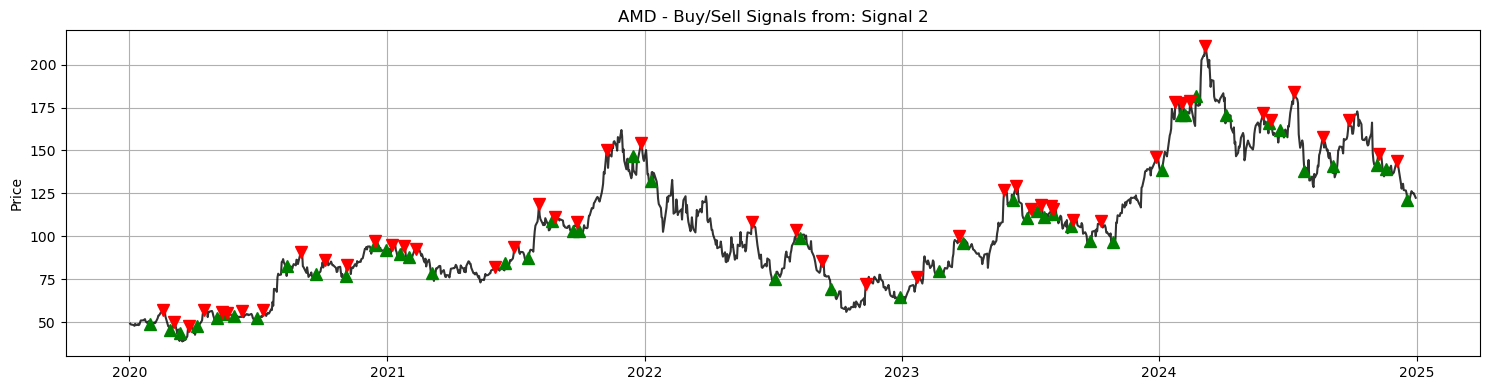

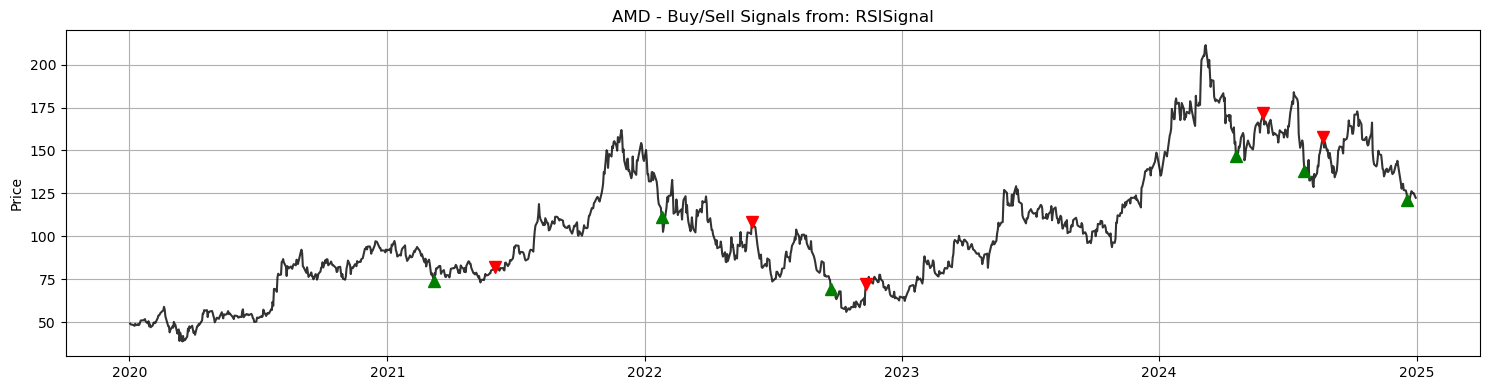

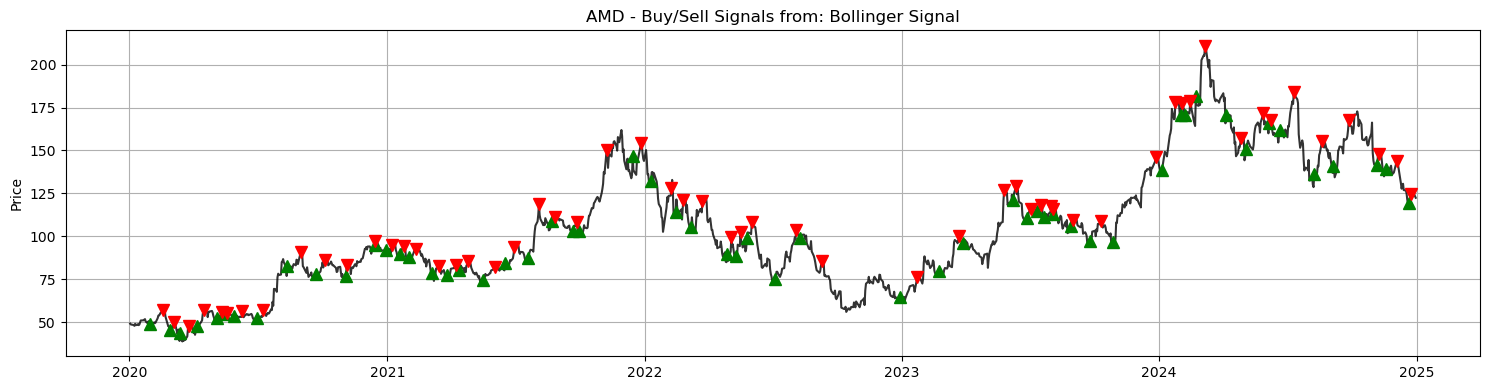

In [11]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, 'AMD', 'Signal 2')
plot_buy_and_sell_signals(signal['rsi_position_change'], test_df_prices, 'AMD', 'RSISignal')
plot_buy_and_sell_signals(signal['bollinger_position_change'], test_df_prices, 'AMD', 'Bollinger Signal')

## Signal 3: Donchian Channel with ADX

#### 3.A) Define signal

In [16]:
def signal03(prices, adx_window_length, adx_threshhold, donchian_window_length):
    
    signals = pd.DataFrame(index=prices.index)
    signals['signal'] = 0.0

    adx = compute_adx(prices, adx_window_length)
    donchian_sig = donchian_signals(prices, donchian_window_length)
    donchian_sig_array = np.asarray(donchian_sig['signal'])

    position = np.zeros(len(prices), dtype=float)
    holding = 0
    for i in range(len(prices)):
        if np.isnan(adx[i]):
            continue
        if holding == 0 and donchian_sig_array[i] == 1 and adx[i] > adx_threshhold:
            holding = 1
        elif holding == 1 and donchian_sig_array[i] == 0 and adx[i] > adx_threshhold:
            holding = 0
        position[i] = holding

    signals['signal'] = position
    signals['position_change'] = signals['signal'].diff().fillna(0)
    signals['donchian_position_change'] = donchian_sig['position_change']
    signals.iloc[0, signals.columns.get_loc('position_change')] = 0

    return signals

#### 3.B) Gridsearch best Parameters

In [17]:
param_grid = {
    'adx_window_length': [8, 10, 12, 14, 16, 18, 20],
    'adx_threshhold': [20, 22, 25, 26, 28, 30],
    'donchian_window_length': [8, 10, 12, 14, 16, 18, 20],
    
}

all_best_params = {}
for ticker in tickers:
    prices = test_df_prices[ticker]
    best_params, best_score, results_df = gridsearch_strategy(price=prices, param_grid=param_grid, signal_fn=signal03, metric='sharpe')
    all_best_params[ticker] = best_params
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)
    print(f"\n=== Results for {ticker} ===")
    print(results_df.head(3))


=== Results for TSLA ===
   adx_window_length  adx_threshhold  donchian_window_length     cumret  b&h cumret    sharpe  b&h sharpe
0                  8              25                       8  68.891532   13.552015  2.056838    1.134808
1                  8              20                       8  58.234033   13.552015  1.991513    1.134808
2                  8              26                       8  55.669051   13.552015  1.983721    1.134808

=== Results for AAPL ===
   adx_window_length  adx_threshhold  donchian_window_length    cumret  b&h cumret    sharpe  b&h sharpe
0                 10              28                       8  3.839174    2.464475  1.919532    0.945262
1                 12              22                      10  3.424082    2.464475  1.686375    0.945262
2                 14              20                      10  3.188251    2.464475  1.678082    0.945262

=== Results for AMD ===
   adx_window_length  adx_threshhold  donchian_window_length    cumret  b&h cum

#### 3.C) Evaluate parameters on test set

In [18]:
test_results = {}
for ticker in tickers:
    params = all_best_params[ticker]
    prices = test_df_prices[ticker]
    signal = signal03(prices=prices, **params)
    results = backtest_strategy(prices, signal['signal'])
    test_results[ticker] = {
    'Strategy Cumulative Return': results['Strategy Cumulative Return'],
    'BuyHold Cumulative Return': results['BuyHold Cumulative Return'],
    'Strategy Sharpe': results['Strategy Sharpe'],
    'BuyHold Sharpe': results['BuyHold Sharpe'],
    'Sharpe Delta': results['Sharpe Delta'],
    'Strategy Max Drawdown': results['Strategy Max Drawdown'],
    'BuyHold Max Drawdown': results['BuyHold Max Drawdown'],
    'Strategy Volatility': results['Strategy Volatility'],
    'BuyHold Volatility': results['BuyHold Volatility']}
        
df_test_results = pd.DataFrame.from_dict(test_results)
df_test_results

,TSLA,AAPL,AMD
Strategy Cumulative Return,68.891532,3.839174,4.741380
BuyHold Cumulative Return,13.552015,2.464475,1.493686
Strategy Sharpe,2.056838,1.919532,1.138460
BuyHold Sharpe,1.134808,0.945262,0.611055
Sharpe Delta,0.922030,0.974270,0.527404
Strategy Max Drawdown,0.337354,0.117494,0.246593
BuyHold Max Drawdown,0.736322,0.314273,0.654499
Strategy Volatility,0.467619,0.172647,0.366186
BuyHold Volatility,0.671894,0.316891,0.524764


#### 3.D) Analyisis and interpretation

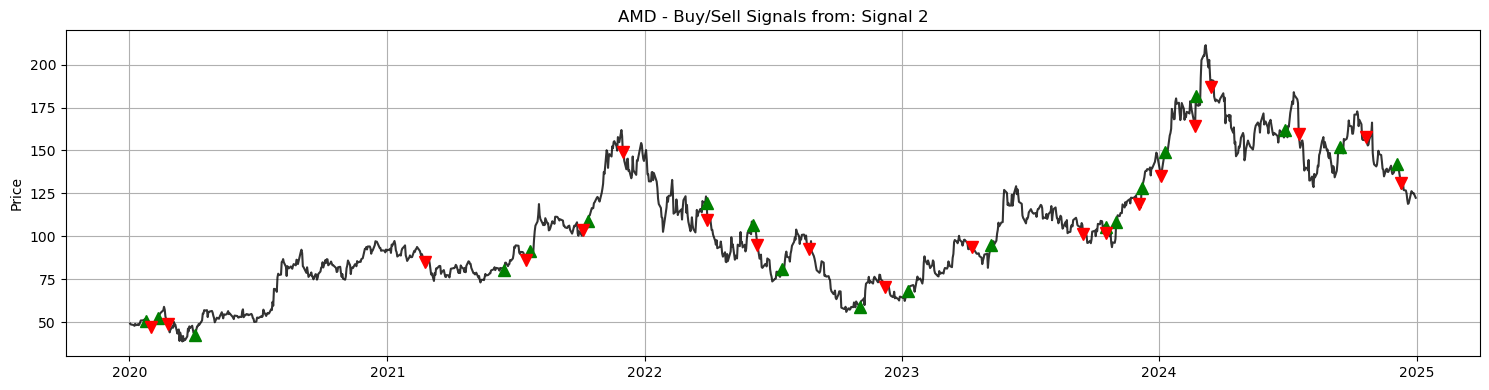

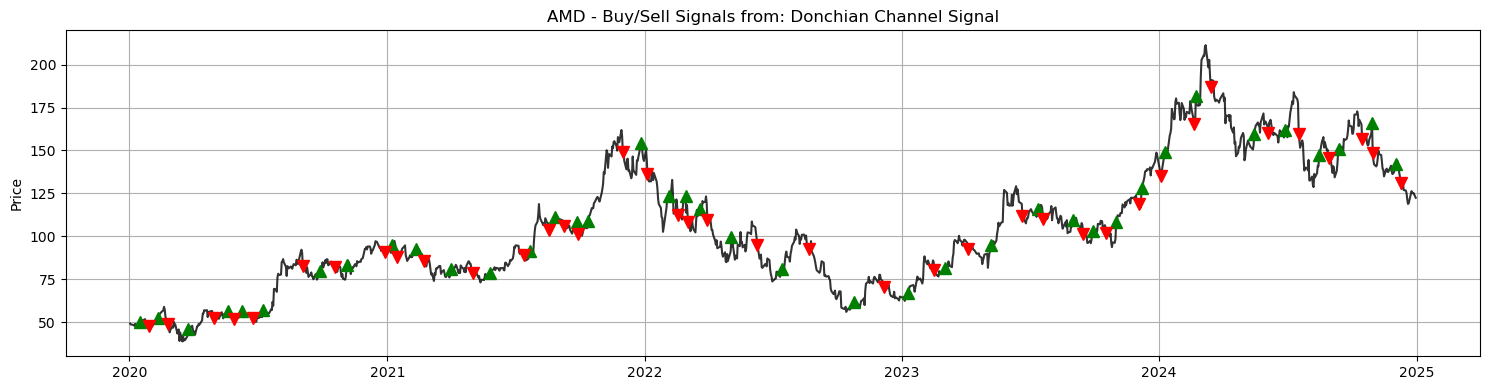

In [19]:
plot_buy_and_sell_signals(signal['position_change'], test_df_prices, 'AMD', 'Signal 2')
plot_buy_and_sell_signals(signal['donchian_position_change'], test_df_prices, 'AMD', 'Donchian Channel Signal')